
- does lspi work?
    - linear yes...
    - rbf no...
- how does linear lspi behave according to D? 
    - only optimal - yes
    - noisy optimal - yes
    - completely random - no

- dimensionality

- how does rbf lspi behave according to D? 
    - only optimal 
    - noisy optimal
    - completely random

In [301]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="husl")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *
from algo.fa import LinearQ3

from logger import *
setup_logging(default_level=logging.INFO)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [302]:
# preprocess reward if needed
def reward_fn1(s, a):
    pos, v = s
    return 1 if pos > 0.45 else 0

def reward_fn2(s, a):
    pos, v = s
    return 10*(pos + 0.6)**2

def reward_fn3(s, a):
    pos, v = s
    if pos < -0.75:
        return 0
    elif pos < 0.25:
        return -1
    else:
        return 5


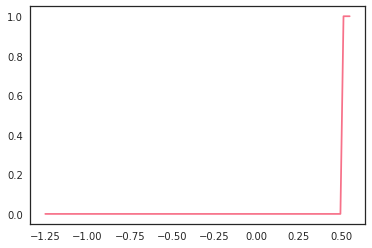

In [94]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn1([x, 0], 0) for x in xx]
plt.plot(xx, r)

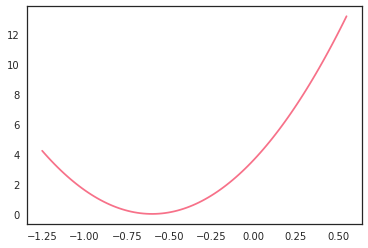

In [90]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn2([x, 0], 0) for x in xx]
plt.plot(xx, r)

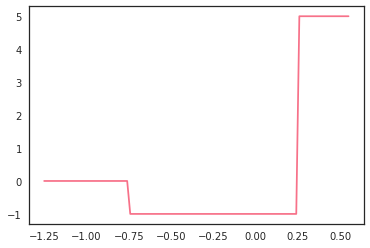

In [125]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn3([x, 0], 0) for x in xx]
plt.plot(xx, r)

In [348]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [349]:
# linear basis func
p_linear = 3
q_linear = 3
phi_linear = get_linear_basis()
psi_linear = phi_linear

include_action = False
include_action_to_basis = True


n_component = 10
n_rbf = 2
p_rbf = n_component * n_rbf + int(include_action)
q_rbf = n_component * n_rbf + int(include_action)

# https://scholarworks.umass.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1222&context=cs_faculty_pubs
phi_rbf = get_rbf_basis(env, n_component, include_action_to_basis, include_action)
psi_rbf = phi_rbf

phi = phi_rbf
p = p_rbf

precision = 1e-2
eps = 0.0
gamma = 0.99
action_list = range(env.action_space.n)

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 199 @ Episode 200/200 (-200.0)

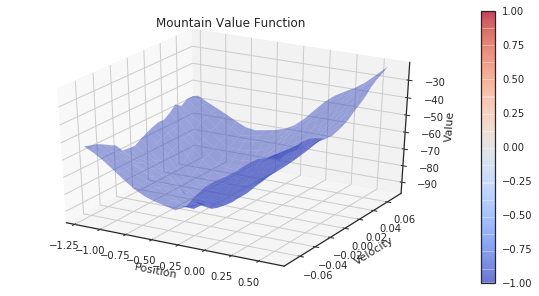

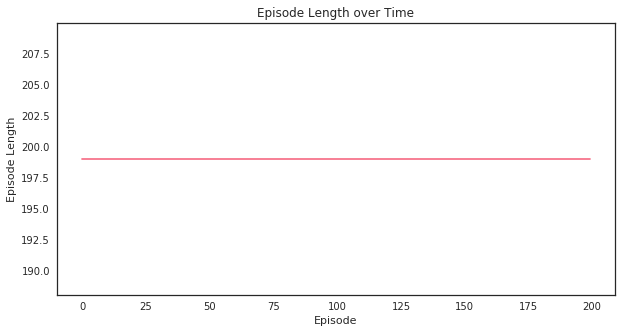

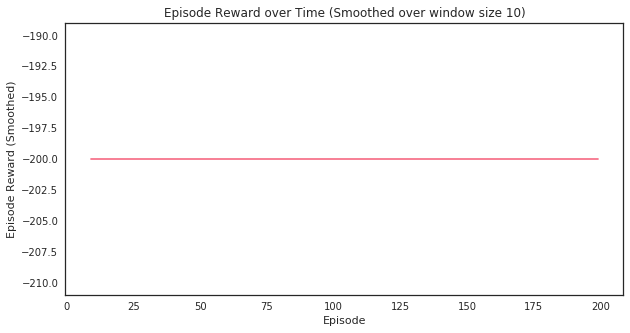

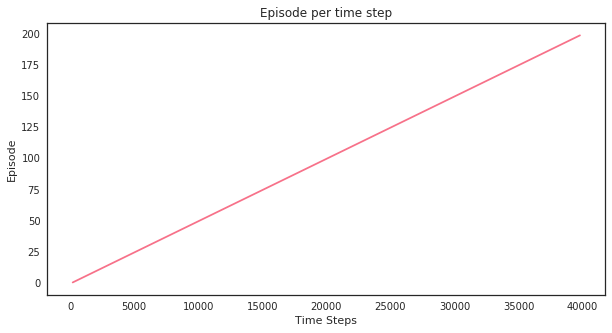

(<matplotlib.figure.Figure at 0x7f62833d7ef0>,
 <matplotlib.figure.Figure at 0x7f6281b28d30>)

In [351]:
# one reason: basis function includes action (remove... but how?)
# swapping with the original code copy paste
# estimator update?
mdp_solver = LinearQ3(env=env,
                      phi=phi,
                      action_list=action_list,
                      n_episode=200,
                      epsilon=0.2,
                      epsilon_decay=0.95,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve(reward_fn=None)
plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)

In [324]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        #c = np.random.uniform(-0.1, 0.1)
        c = 0
        return 0 if v <= c else 2

class OppositeNearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.1, 0.1)
        return 0 if v > c else 2
    
pi_near = NearExpertPolicy()
pi_near_ops = OppositeNearExpertPolicy()
pi_random = RandomPolicy2(action_list)
#D, stats = sim.simulate(pi=pi_expert, n_trial=1, n_episode=100, return_stats=True)

# todo: purify
pi_list = [pi_random, pi_near_ops, pi_near, pi_expert]
mix_ratio = [0.0, 0.2, 0.2, 0.8]
sample_size = 100
D = sim.simulate_mixed(env, pi_list, sample_size, mix_ratio)

Step 136 @ Episode 80/80 (-143.0)

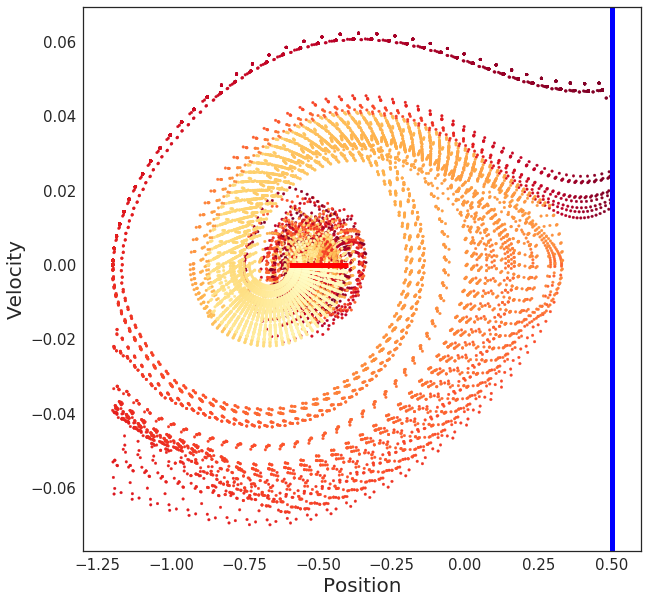

In [325]:
#plot_cost_to_go_mountain_car(env, pi_irl._estimator)
#plot_episode_stats(stZts, smoothing_window=5)
#dir(Simulator.to_matrixZ
plot_trajectory_mountain_car(D)
# must run this!!!
D_mat = Simulator.to_matrix(D)

(array([ 16216.,   3816.,   3706.,   1149.,    702.,    719.,    391.,
           490.,    259.,    238.]),
 array([  5.51639636e-10,   1.20935310e+00,   2.41870620e+00,
          3.62805929e+00,   4.83741239e+00,   6.04676549e+00,
          7.25611859e+00,   8.46547169e+00,   9.67482479e+00,
          1.08841779e+01,   1.20935310e+01]),
 <a list of 10 Patch objects>)

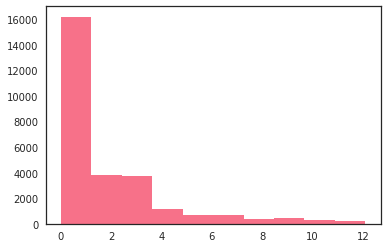

In [259]:
s = np.vstack(D_mat[:, 0])
a = np.vstack(D_mat[:, 1])
r = np.vstack([reward_fn2(s,a) for s, a in zip(s, a)])
plt.hist(r)

In [346]:
def solve_mountain_car(p, phi, gamma, precision, eps, D, reward_fn=None, max_iter=10):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=reward_fn,
                max_iter=max_iter)

    W, w_list = lspi.solve()
    return W, w_list
print("batch data size {}".format(np.array(D_mat).shape))
#W_linear = solve_mountain_car_linear(p_linear, phi_linear, gamma, precision, eps, D_mat, reward_fn)
w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 10)

INFO:root:fitting D of the dimension:
(17984, 5)


batch data size (17984, 5)


INFO:root:lspi norm 3333.9595452706653
INFO:root:lspi norm 865.0629500830358
INFO:root:lspi norm 205.87711276807957
INFO:root:lspi norm 271.073897042382
INFO:root:lspi norm 78.41831165584057
INFO:root:lspi norm 147.49187348519047
INFO:root:lspi norm 17.670219853195235
INFO:root:lspi norm 5.1694321039660815
INFO:root:lspi norm 0.37852153331464217
INFO:root:lspi norm 0.0004163743498844728


Step 198 @ Episode 30/30 (-200.0)

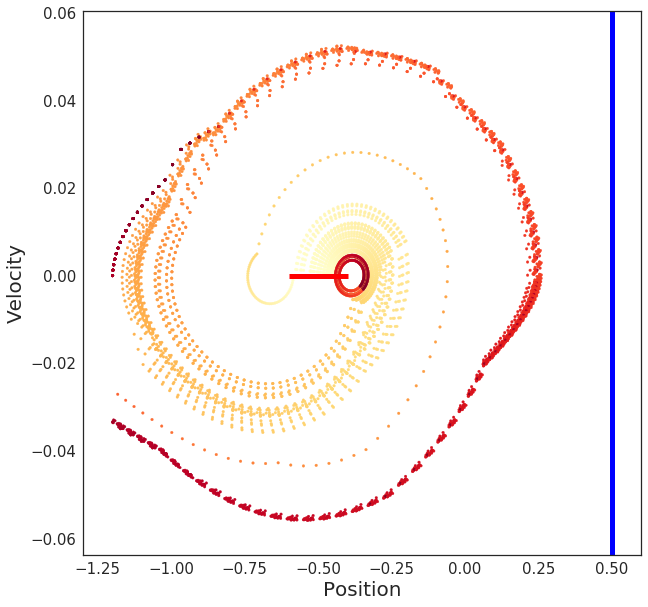

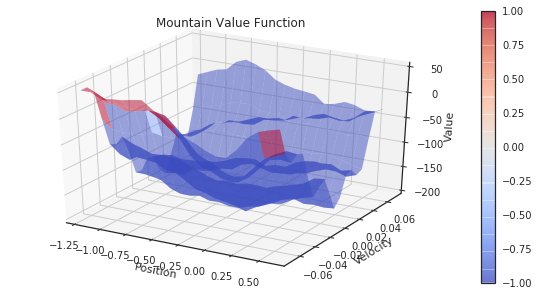

Step 198 @ Episode 30/30 (-200.0)

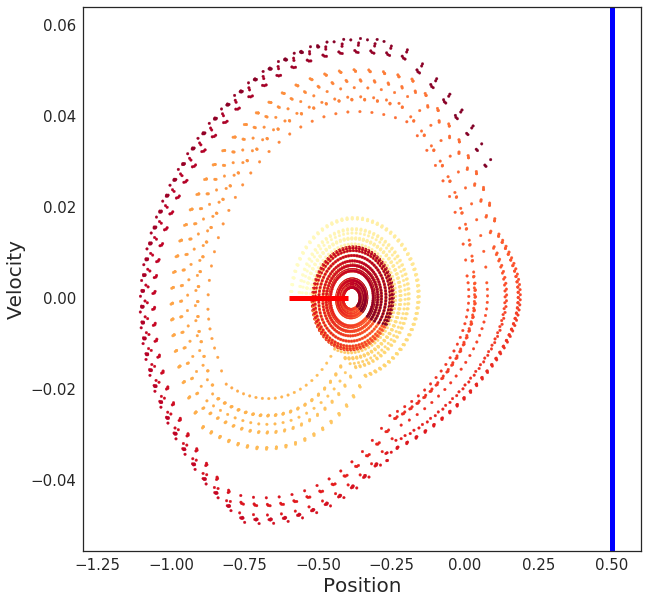

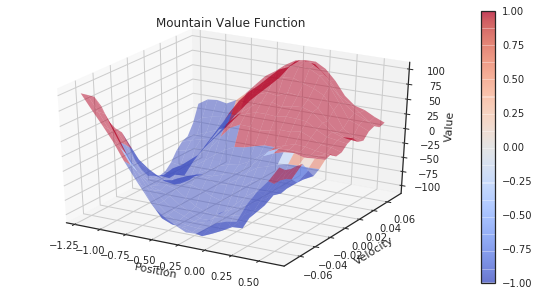

Step 153 @ Episode 30/30 (-149.0)

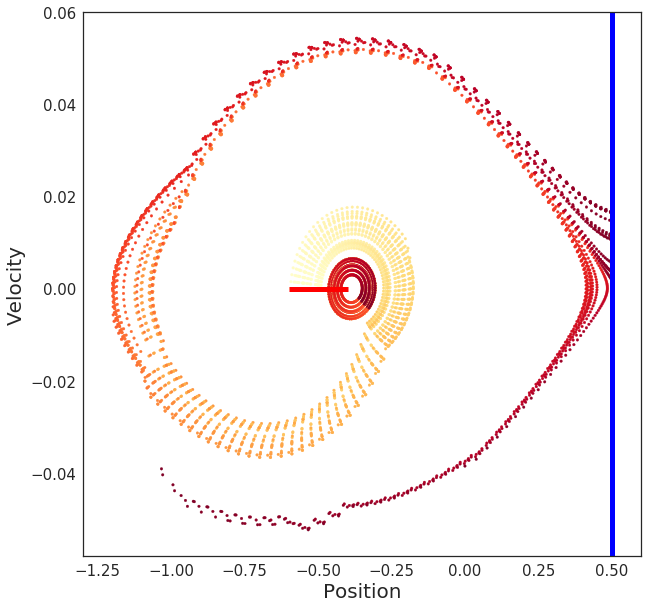

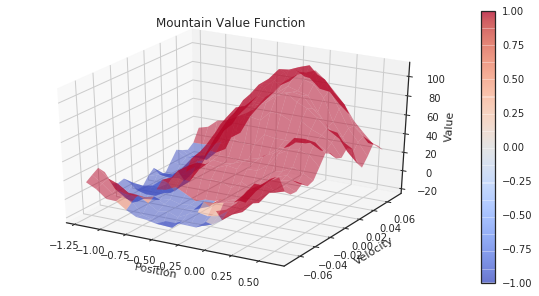

Step 198 @ Episode 30/30 (-200.0)

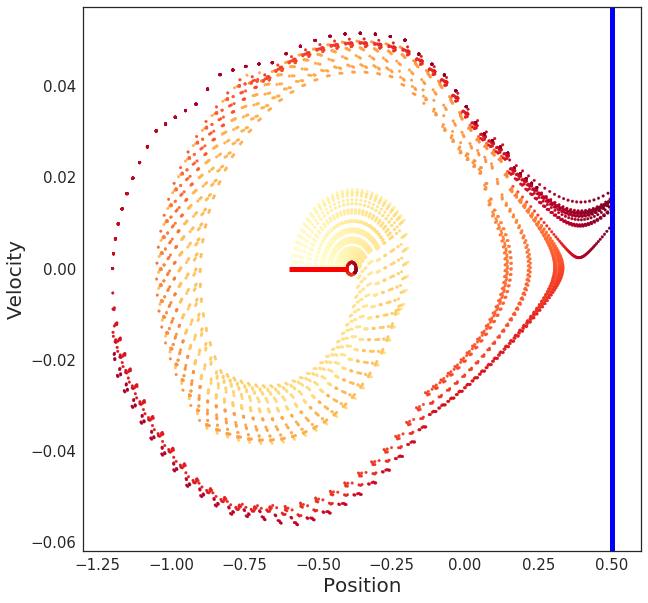

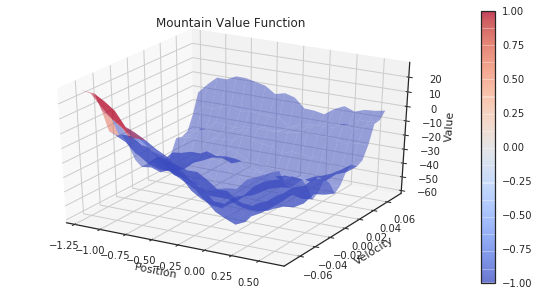

Step 198 @ Episode 30/30 (-200.0)

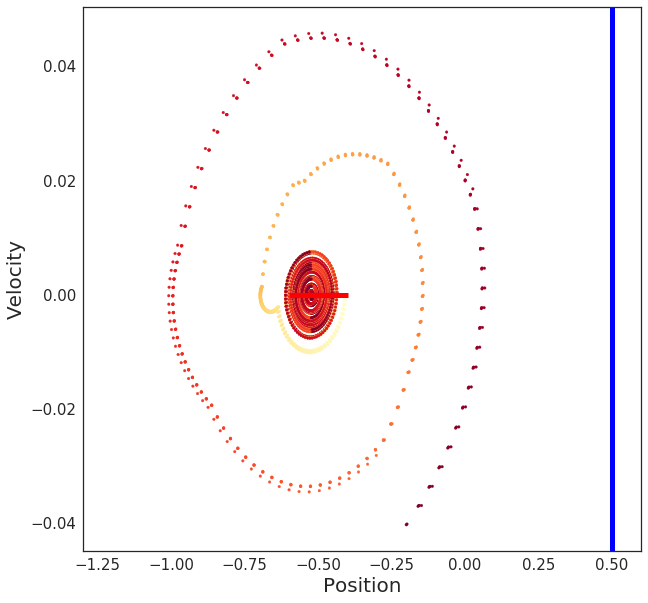

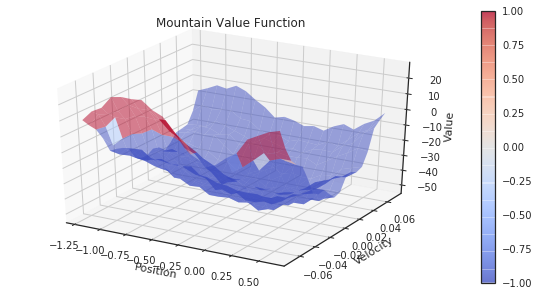

Step 198 @ Episode 30/30 (-200.0)

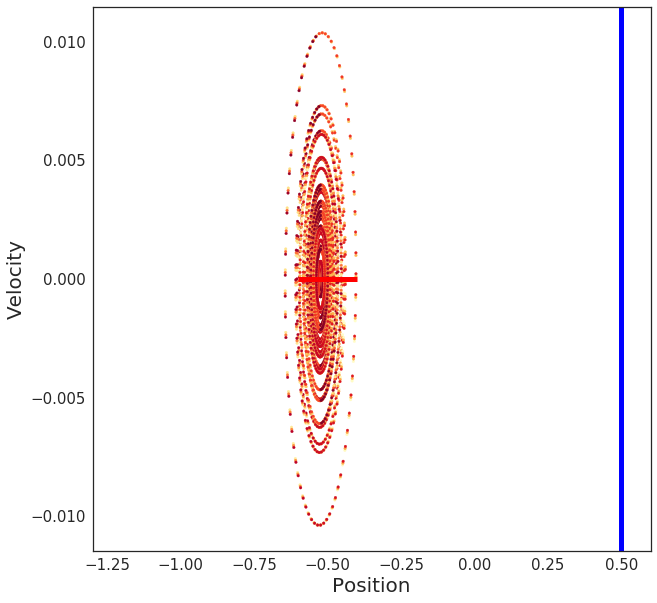

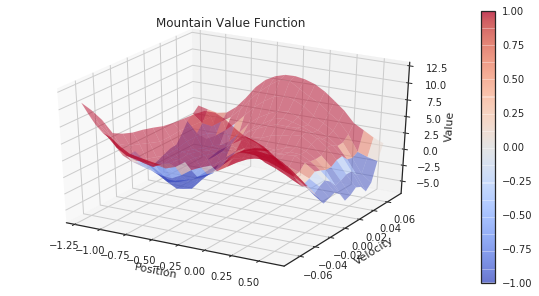

Step 198 @ Episode 30/30 (-200.0)

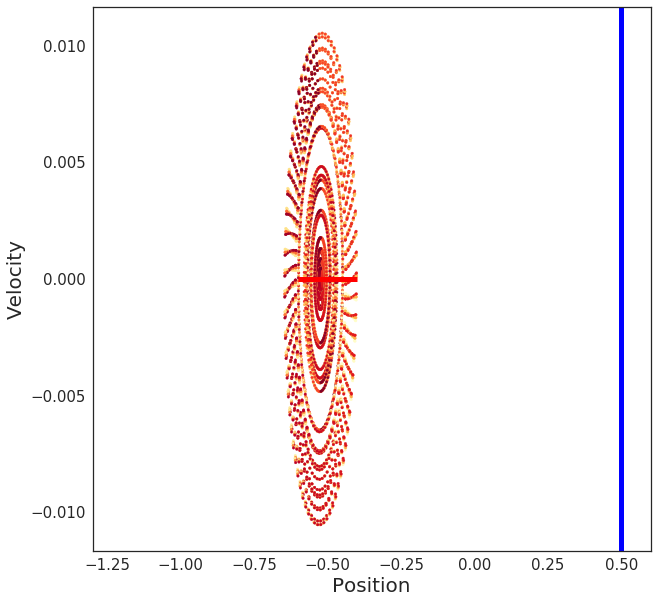

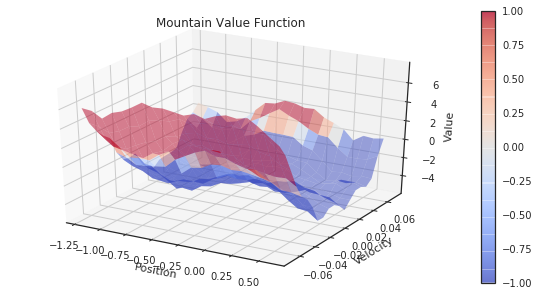

Step 198 @ Episode 30/30 (-200.0)

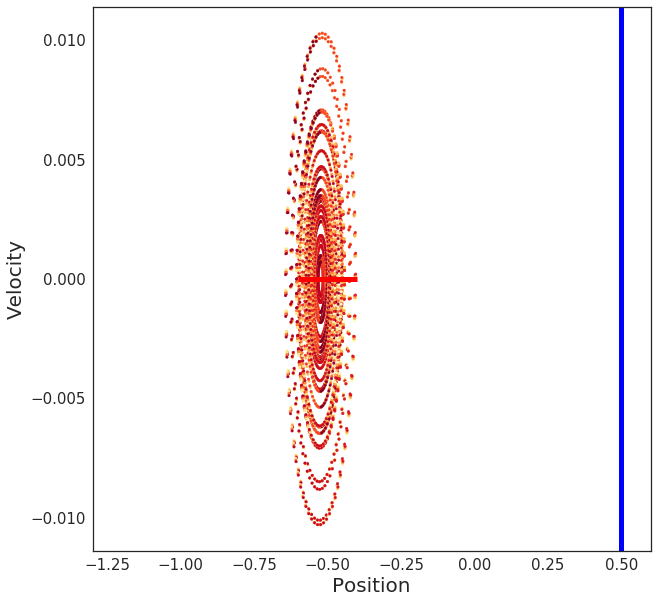

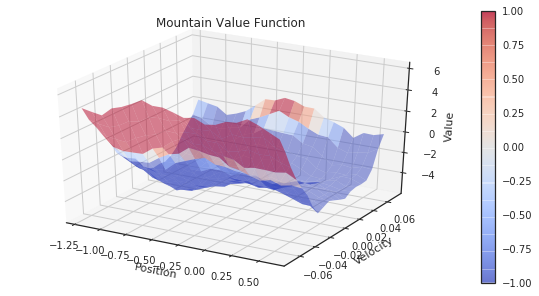

Step 198 @ Episode 30/30 (-200.0)

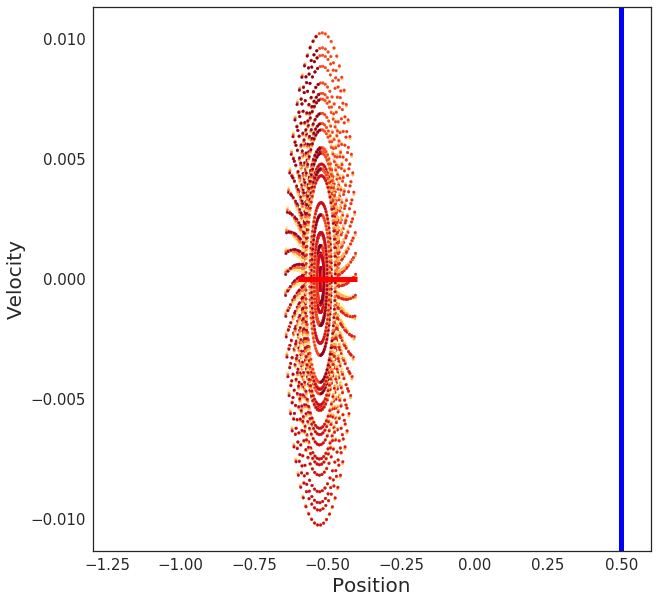

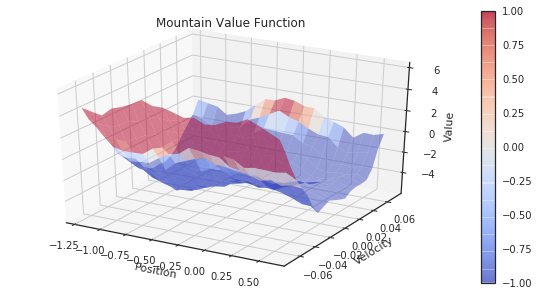

Step 198 @ Episode 30/30 (-200.0)

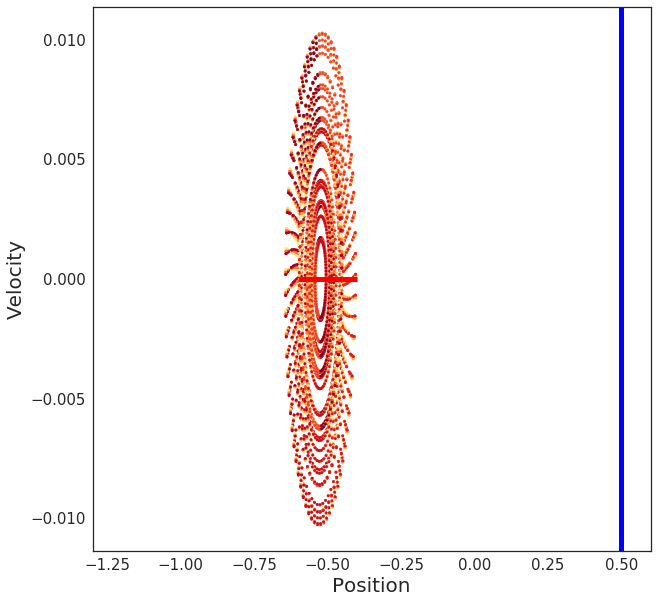

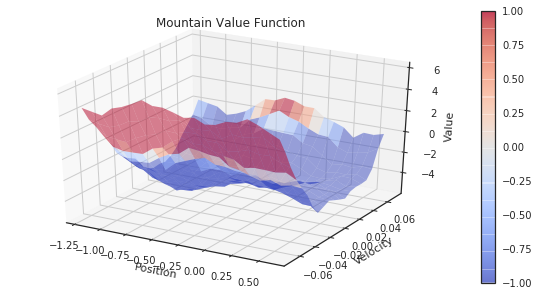

In [347]:
for w in w_list: 
    pi_star = LinearQ2(action_list=action_list, phi=phi_rbf, W=w)
    #pi_star = LinearQ2(action_list=action_list, phi=phi_linear, W=W_linear)
    D_star, stats = sim.simulate(pi=pi_star, n_trial=1, n_episode=30, return_stats=True)
    plot_trajectory_mountain_car(D_star)    
    plot_cost_to_go_mountain_car(env, pi_star)
    #plot_episode_stats(stats, smoothing_window=5)

In [ ]:
plt.hist([env.observation_space.sample() for x in range(10000)])